<center style="border-radius:10px;
padding: 3rem 2rem;
border: 3px solid #FCBE03;
">
<h1 style="color:#FCBE03; 
font-size:3.0rem;
margin:0;
">Using 🤗 Transformers for the first time</h1>
<h2 style="color:#FCBE03; 
font-size:2.0rem;
margin-top:1rem;
margin-bottom:2.5rem;
">Finetuning bert-base-uncased</h2>
<a href="https://kaggle.com/shreydan" style="color: white;
background-color: #FCBE03;
border-radius: 25px;
padding: 1rem 1.5rem;
text-decoration: none;
">@shreydan</a>
</center>

> **Hello everyone!** This is my first time using transformers and fine-tuning for a specific task. After many failed versions, referencing many notebooks and lot of time spent in docs later -- I was able to get a decent start with my transformers journey!

### I also made an EDA Notebook which you can check out here: [notebook](https://www.kaggle.com/code/shreydan/first-look-at-data-eda-read-some-essays)

<center style="border-radius:10px;
padding: 1rem;
border: 3px solid #731eb0;
">
<h3 style="color:#731eb0;
">📑️ first look at data | EDA | read some essays</h3>
</center>

# Imports
<div style="width:100%;height:0;border-bottom: 3px solid #EAB209;margin-bottom: 1rem;"></div>

- I used AutoModel: which let's me import a pre-trained model for inference/fine-tuning.
- I used AutoTokenizer: a pre-trained tokenizer ofc but since its an AutoClass it  chooses the right tokenizer to use with the model. Pretty cool!!!
- I chose to write the training loop from scratch using Pytorch
- Also if anyone can help me figure out the `tokenizers parallelism warning` and how to properly deal with it, please comment, I chose to set the environ flag for now.

In [1]:
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc

# ----------
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import transformers
print('transformers version:',transformers.__version__)

transformers version: 4.20.1


# Config
<div style="width:100%;height:0;border-bottom: 3px solid #EDD608;margin-bottom: 1rem;"></div>

- The model I used is the one in docs `bert-base-uncased`, uncased means the text has been converted to lower case during pre-tokenization
- max_length is for the maximum sequence length and the model's max_length = 512 and most of the essay lengths were in that region.
- The learning rate was crucial, I initally used lr=3e-4 but I wasn't getting any good results. After going through docs and searching for good learning rates for bert, order of 10**-5 seemed to be right and my results improved significantly
- batch_size set to 16 coz anything more I had CUDA out of memory issues
- scheduler: I used CosineAnnealingWarmRestarts because it was the one which was recommended in the docs

In [3]:
config = {
    'model': 'bert-base-uncased',
    'dropout': 0.5,
    'max_length': 512,
    'batch_size': 16,
    'epochs': 5,
    'lr': 2e-5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'scheduler': 'CosineAnnealingWarmRestarts'
}

# Tokenizer, Dataset and DataLoaders
<div style="width:100%;height:0;border-bottom: 3px solid #E4F008;margin-bottom: 1rem;"></div>

- After loading the tokenizer, I used the `encode_plus` method which converted the raw text to tokens as `input_ids` along with it we also get `token_type_ids` and `attention_mask`
- `token_type_ids` are used in cases such in sequence classification and question-answering. [docs](https://huggingface.co/transformers/v3.2.0/glossary.html#token-type-ids)
- `attention_mask` tells the model to what tokens to pay attention to and what to ignore.
- we also truncate till first 512 tokens and pad to max_length
- I used a simple pytorch dataset which takes the df, and generates samples as a dict.
- the inputs dict: `{'input_ids','token_type_ids','attention_mask'}`
- the targets dict: `{'labels'}` I treated this as a multiclass regression problem, the label is a vector of the 6 different types of scores in the dataset.
- then simple dataloaders for the dataset

In [4]:
tokenizer = AutoTokenizer.from_pretrained(config['model'])

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [5]:
df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')

In [6]:
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [7]:
print(df.columns.to_list())

['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


In [8]:
class EssayDataset:
    def __init__(self, df, config, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
        self.max_len = config['max_length']
        self.tokenizer = tokenizer
        self.is_test = is_test
        
    def __getitem__(self,idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                          None,
                                          add_special_tokens=True,
                                          max_length=self.max_len,
                                          truncation=True,
                                          padding='max_length'
                                         )
        inputs = {
            "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long),
            "token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        if self.is_test == True:
            return inputs
        
        label = self.df.loc[idx,self.classes].to_list()
        targets = {
            "labels": torch.tensor(label, dtype=torch.float32),
        }
        
        return inputs, targets
    
    def __len__(self):
        return len(self.df)


In [9]:
train_df, val_df = train_test_split(df,test_size=0.2,random_state=1357,shuffle=True)
print('dataframe shapes:',train_df.shape, val_df.shape)

dataframe shapes: (3128, 8) (783, 8)


In [10]:
train_ds = EssayDataset(train_df, config, tokenizer=tokenizer)
val_ds = EssayDataset(val_df, config, tokenizer=tokenizer)
test_ds = EssayDataset(test_df, config, tokenizer=tokenizer, is_test=True)

In [11]:
train_ds[0][0]['input_ids'].shape

torch.Size([512])

In [12]:
train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=config['batch_size'],
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True
                                          )
val_loader = torch.utils.data.DataLoader(val_ds,
                                         batch_size=config['batch_size'],
                                         shuffle=True,
                                         num_workers=2,
                                         pin_memory=True
                                        )

In [13]:
print('loader shapes:',len(train_loader), len(val_loader))

loader shapes: 196 49


# Model
<div style="width:100%;height:0;border-bottom: 3px solid #C3F307;margin-bottom: 1rem;"></div>

- the `encoder` returns 2 outputs, I turned off `return_dict` to unpack them. The first output is the last hidden state of the model, and the second output is pooled output of the model.
- the outputs we get (BaseModelOutputWithPoolingAndCrossAttentions):
    - last_hidden_state
    - pooler_output
    
    ```python
    >>> odict_keys(['last_hidden_state', 'pooler_output'])
    >>> torch.Size([16, 768]) # 768 is our hidden_size
    ```


- we can also choose the freeze the `encoder` to train the fc layers but eh this is fine.
- there are other pooling options we can use such as `mean pooling` which I'm yet to understand properly.
- the pooled output size can be obtained through `model.config.hidden_size`
- then simple fully-connected layers to get the logits we need


In [14]:
class EssayModel(nn.Module):
    def __init__(self,config,num_classes=6):
        super(EssayModel,self).__init__()
        self.model_name = config['model']
        self.encoder = AutoModel.from_pretrained(self.model_name)
        self.dropout = nn.Dropout(config['dropout'])
        self.fc1 = nn.Linear(self.encoder.config.hidden_size,64)
        self.fc2 = nn.Linear(64,num_classes)
        
    def forward(self,inputs):
        _,outputs = self.encoder(**inputs, return_dict=False)
        outputs = self.dropout(outputs)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        return outputs

# Trainer
<div style="width:100%;height:0;border-bottom: 3px solid #A2F606;margin-bottom: 1rem;"></div>

- **Loss Function:** [MCRMSE](https://www.kaggle.com/competitions/feedback-prize-english-language-learning/discussion/348985)
- **Optimizer:** AdamW, default weight-decay: 1e-2 -- huggingface docs recommend modifying the weight decay for params hence the `get_optim` method
- **Scheduler:** -- you can change the scheduler in the config and Trainer class will perform the scheduler.step() where it's supposed to.
    - ReduceLROnPlateau:: min_lr: 1e-7
    - **CosineAnnealingWithWarmRestarts::** T_0: 2, eta_min: 1e-7
    - StepLR:: step_size: 2
- **steps in every epoch:**
    - set model to train mode
    - train one epoch
        - get inputs, targets
        - move them to GPU
        - calculate loss
        - backprop
        - optim step
        - scheduler step
    - garbage collection and clear cuda cache
    - set model to eval mode
    - validate one epoch
        - get inputs, targets
        - move them to GPU
        - calculate loss
        - scheduler step if scheduler is ReduceLROnPlateau
    - garbage collection and clear cuda cache

In [15]:
class Trainer:
    def __init__(self, model, loaders, config):
        self.model = model
        self.train_loader, self.val_loader = loaders
        self.config = config
        self.input_keys = ['input_ids','token_type_ids','attention_mask']
        
        self.optim = self._get_optim()
        
        self.scheduler_options = {
            'CosineAnnealingWarmRestarts': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5,eta_min=1e-7),
            'ReduceLROnPlateau': torch.optim.lr_scheduler.ReduceLROnPlateau(self.optim, 'min', min_lr=1e-7),
            'StepLR': torch.optim.lr_scheduler.StepLR(self.optim,step_size=2)
        }
        
        self.scheduler = self.scheduler_options[self.config['scheduler']]
        
        self.train_losses = []
        self.val_losses = []
        
    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config['lr'])
        return optimizer

        
    def loss_fn(self, outputs, targets):
        colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
        loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
        return loss
    
    def train_one_epoch(self,epoch):
        
        running_loss = 0.
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        
        for i,(inputs,targets) in enumerate(progress):
            
            self.optim.zero_grad()
            
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            targets = targets['labels'].to(device=config['device'])
            
            outputs = self.model(inputs)
            
            loss = self.loss_fn(outputs, targets)
            running_loss += loss.item()
            
            loss.backward()
            self.optim.step()
            
            if self.config['scheduler'] == 'CosineAnnealingWarmRestarts':
                self.scheduler.step(epoch-1+i/len(self.train_loader)) # as per pytorch docs
            
            del inputs, targets, outputs, loss
            
        if self.config['scheduler'] == 'StepLR':
            self.scheduler.step()
            
        train_loss = running_loss/len(self.train_loader)
        self.train_losses.append(train_loss)
        
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        
        running_loss = 0.
        progress = tqdm(self.val_loader, total=len(self.val_loader))
        
        for (inputs, targets) in progress:
            
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            targets = targets['labels'].to(device=config['device'])
            
            outputs = self.model(inputs)
            
            loss = self.loss_fn(outputs, targets)
            running_loss += loss.item()
            
            del inputs, targets, outputs, loss
            
        
        val_loss = running_loss/len(self.val_loader)
        self.val_losses.append(val_loss)
        
        if config['scheduler'] == 'ReduceLROnPlateau':
            self.scheduler.step(val_loss)
            
    
    def test(self, test_loader):
        
        preds = []
        for (inputs) in test_loader:
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())
            
        preds = torch.concat(preds)
        return preds
    
    def fit(self):
        
        fit_progress = tqdm(
            range(1, self.config['epochs']+1),
            leave = True,
            desc="Training..."
        )
        
        for epoch in fit_progress:
            
            self.model.train()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | training...")
            self.train_one_epoch(epoch)
            self.clear()
            
            self.model.eval()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | validating...")
            self.valid_one_epoch(epoch)
            self.clear()

            print(f"{'-'*30} EPOCH {epoch} / {self.config['epochs']} {'-'*30}")
            print(f"train loss: {self.train_losses[-1]}")
            print(f"valid loss: {self.val_losses[-1]}\n\n")
            
    
    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()

# Training
<div style="width:100%;height:0;border-bottom: 3px solid #7FF906;margin-bottom: 1rem;"></div>

In [16]:
model = EssayModel(config).to(device=config['device'])
trainer = Trainer(model, (train_loader, val_loader), config)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
trainer.fit()

Training...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 1 / 5 ------------------------------
train loss: 1.1571817808613485
valid loss: 0.5098667850299757




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 2 / 5 ------------------------------
train loss: 0.5512028014173314
valid loss: 0.49883413923029996




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 3 / 5 ------------------------------
train loss: 0.5002027471758881
valid loss: 0.507232337581868




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 4 / 5 ------------------------------
train loss: 0.47264562167075214
valid loss: 0.48637479239580583




  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 5 / 5 ------------------------------
train loss: 0.46035708304570644
valid loss: 0.5024625227159384




# Results
<div style="width:100%;height:0;border-bottom: 3px solid #EAB209;margin-bottom: 1rem;"></div>

In [18]:
losses_df = pd.DataFrame({'epoch':list(range(1,config['epochs'] + 1)),
                          'train_loss':trainer.train_losses, 
                          'val_loss': trainer.val_losses
                         })

In [19]:
losses_df

,epoch,train_loss,val_loss
0,1,1.157182,0.509867
1,2,0.551203,0.498834
2,3,0.500203,0.507232
3,4,0.472646,0.486375
4,5,0.460357,0.502463


# Plots
<div style="width:100%;height:0;border-bottom: 3px solid #EDD608;margin-bottom: 1rem;"></div>

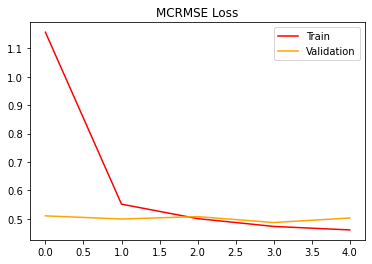

In [20]:
plt.plot(trainer.train_losses, color='red')
plt.plot(trainer.val_losses, color='orange')
plt.title('MCRMSE Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Comparison
<div style="width:100%;height:0;border-bottom: 3px solid #0DFC25;margin-bottom: 1rem;"></div>

As you can see, I also tried the classic NLP methods, they were from scratch as well, even the embedding layer, could've used stuff like Word2Vec but I'm new to NLP so went with scratch implementations and ofcourse the results are not that good. Using a Byte-Pair encoding tokenizer improved the results slightly which was good to see, I used huggingface tokenizer for that as well but not pre-trained ofc.

![lstm](https://i.imgur.com/6vAeO6a.jpeg)

# Closing
<div style="width:100%;height:0;border-bottom: 3px solid #EAB209;margin-bottom: 1rem;"></div>

## Thank you for taking the time to go through my notebook!

- Would appreciate feedback in the comments, please do let me know what I could've done better, how I can improve my training loops and especially using regarding usage of transformers.
- **Upvote if you liked this notebook, really helps a lot as I'm currently new to NLP.**
- **Follow if you like my work! :)**

## References:

- [FB3: RoBERTa PyTorch Baseline - KFolds + W&B 🚀 by @heyytanay](https://www.kaggle.com/code/heyytanay/fb3-roberta-pytorch-baseline-kfolds-w-b) - his work is amazing, I learnt a lot from just reading his notebooks since I joined kaggle! Do checkout his work.
- [HuggingFace AutoClass](https://huggingface.co/docs/transformers/main/autoclass_tutorial)
- [HuggingFace training & Finetuning with Pytorch](https://huggingface.co/transformers/v3.3.1/training.html#pytorch)
- [tez: fb3 training kernel by @abhishek](https://www.kaggle.com/code/abhishek/tez-fb3-training-kernel) - he basically taught me Pytorch, creating datasets andwriting training loops. Checkout his youtube tutorials, pretty cool!
- [HuggingFace training](https://huggingface.co/docs/transformers/main/training)